<a href="https://colab.research.google.com/github/mloyorev/Theory/blob/main/Newtons_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Newton's Method via JAX**

We use the following imports:



In [2]:
import jax
import jax.numpy as jnp
from scipy.optimize import root
import matplotlib.pyplot as plt

We are running the following GPU:

In [3]:
!nvidia-smi

Sun Dec 24 17:28:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## **Newton method in one dimension**

Let $f:\mathbb{R}→\mathbb{R}$ be a function.

A root of $f$ is an $x^{*}\mathbb{R}$ such that $f(x^{*})=0$.

Newton's method for solving for the root of $f$ involves iterating with the map $q$ defined by:

$$q(x)=x-\frac{f(x)}{f'(x)}$$

Here is a function called newton that takes a function $f$, iterates from $x_0$ and returns an approximation of a fixed point $x^{*}$.

In [4]:
def newton(f,         # Function f: R -> R
           x_0,       # Initial condition
           tol=1e-5): # Stopping criterion

  f_prime = jax.grad(f)           # Automatic differention in order to find f'
  def q(x):                       # Define q for Newton's method
    return x - f(x) / f_prime(x)

  error = tol + 1                 # Initialize: - Error
  x = x_0                         #             - Initial condition

  while error > tol:              # Iterative process
    y = q(x)
    error = abs(x - y)
    x = y

  return x

Let's test the Newton's algorithm with a function $f$ defined by

$$f(x)=\sin\left(4\cdot\left(x-\frac{1}{4}\right)\right)+x+x^{20}-1$$

In [5]:
f = lambda x: jnp.sin(4 * (x - 1/4)) + x + x ** 20 - 1 # Define f
                                                       # 'lambda x:' is useful for briefly declaring functions
x = jnp.linspace(0,1,100)                              # Define the subset of R for the iterative procedure

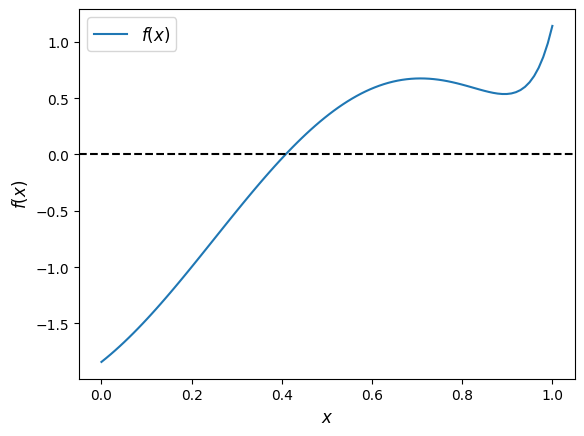

In [6]:
fig, ax = plt.subplots()             # Creates the figure and axes of the graph
ax.plot(x,f(x),label='$f(x)$')       # Plot the function and assign a label to it
ax.axhline(ls='--',c='k')            # Plot the function f(x)=0 with dashed and black style
ax.set_xlabel('$x$',fontsize=12)     # Set axes labels
ax.set_ylabel('$f(x)$',fontsize=12)
ax.legend(fontsize=12)               # Set the fotnsize of the legend
plt.show()                           # Display the graph

In [7]:
newton(f,0.2)

Array(0.4082935, dtype=float32, weak_type=True)

Additionally, we can generate a function that finds the roots for any function and initial point in the domain.

In [8]:
def newton_graph(f,x_0,dev):
  p = newton(f,x_0) # Apply Newton's method to find the roots

  xmin = (1-dev)*p  # Generates the space on which the iterative process is generated
  xmax = (1+dev)*p
  x = jnp.linspace(xmin,xmax,100)

  fig, ax = plt.subplots()                          # Create the graph
  ax.plot(x,f(x),label='$f(x)$',color='steelblue')
  ax.axhline(ls='--',c='k')
  ax.set_xlabel('$x$',fontsize=12)
  ax.set_ylabel('$f(x)$',fontsize=12)
  ax.legend(fontsize=12)

  ax.plot(p, 0, "go", ms=6, alpha=0.75)             # Graph a point that indicates the Newton's fixed point
  ax.annotate(r"$x^{*}$="+str(round(p,4)),xy=(p,0),xycoords="data",xytext=(10,-20),textcoords="offset points",fontsize=12)

  plt.show()


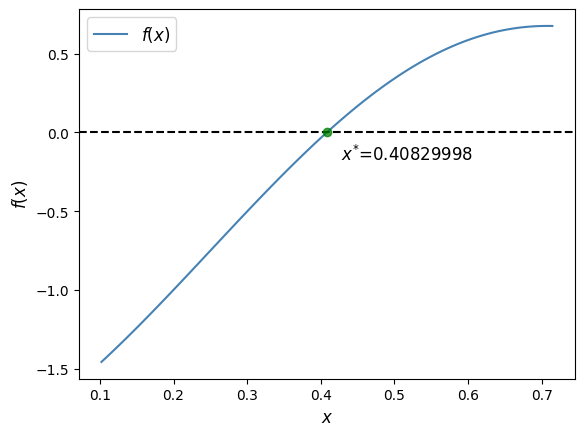

In [9]:
newton_graph(f,0.2,0.75)

We test this function with

$$g(x)=\log(x)+x^2$$

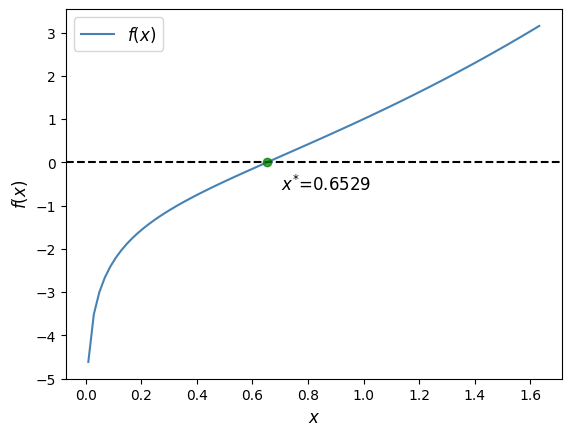

In [10]:
g = lambda x: jnp.log(x) + x**2
newton_graph(g,0.2,1.5)

## **Newton's method in more than one dimension**

Let's move up to higher dimensions.

We describe a **market equilibrium problem**. The market is is for any $n$ goods.

The **supply function** for the $i$-th good is

$$q_{i}^{s}(p)=b_{i}\sqrt{p_{i}}$$

which we write in vector form as

$$q^{s}(p)=b\sqrt{p}$$

where $\sqrt{p}$ is que square root of each $p_{i}$ and $b\sqrt{p}$ is the vector formed by taking the pointwise product $b_{i}\sqrt{p_{i}}$ at each $i$.

The **demand function** in vector form is

$$q^{d}=\exp(-Ap)+c$$

where $A$ is an $n\times n$ matrix, $c$ is an $n\times 1$ vector and $\exp$ acts element-by-element on the vector $-Ap$.

The **excess demandad function** is

$$e(p)=\exp(-Ap)+c-b\sqrt{p}$$

An **equilibrium price vector** is an $n$-vector $p^{*}$ such that $e(P^{*})=0$

We use a **multivariate version of Newton's method** to compute the equilibrium price.

The rule for updating a guess $p_{n}$ of the equilibrium price is

$$p_{n+1}=p_{n}-J_{e}(p_{n})^{-1}e(p_{n})$$

where J_{e}(p_{n}) is the **jacobian** of $e$ evaluated at $p_{n}$.

Iterations starts from initial guess $p_0$.

In [11]:
def newton_n(f,             # Function f:Rn->R
             x_0,           # Initial condition
             tol=1e-5,      # Stopping criterion
             max_iter=15):  # Maximum number of iterations allowed

  x = x_0
  f_jac = jax.jacobian(f) # Jacobian matrix of f with automatic differentiation

  @jax.jit   # Set up Just-In-Time compilation
  def q(x):  # Newton's method algorithm
    return x - jnp.linalg.solve(f_jac(x),f(x))

  error = tol + 1  # Initialize: - error
  n = 0            #             - Number of iterations

  while error > tol:
    n += 1
    if(n > max_iter):
      raise Exception('Max iteration reached without convergence')
    y = q(x)
    error = jnp.linalg.norm(x - y)
    x = y
    print(f'iteration {n}, error = {error}')
  return x

In [12]:
# Excess demand function
def e(p,A,b,c):
  return jnp.exp(- A @ p) + c - b * jnp.sqrt(p)

In [13]:
jnp.ones(4)

Array([1., 1., 1., 1.], dtype=float32)

In [14]:
dim = 5_000 # Dimension of matrix A
seed = 32

key = jax.random.PRNGKey(seed)         # Pseudorandom number generation key
A = jax.random.uniform(key, [dim,dim]) # Generates random numbers uniformly distributed in the range [0, 1)
s = jnp.sum(A, axis=0)                 # The sum of the columns of matrix A is calculated
A = A / s                              # Normalizes the matrix so that the sum of each column is equal to 1

b = jnp.ones(dim)  # Vector of ones of dimension 1 x dim
c = jnp.ones(dim)  # Vector of ones of dimension 1 x dim

In [15]:
init_p = jnp.ones(dim)  # Set up an initial condition p_0

In [16]:
p = newton_n(lambda p: e(p,A,b,c), init_p).block_until_ready()

iteration 1, error = 29.97745704650879
iteration 2, error = 5.092828750610352
iteration 3, error = 0.10971649736166
iteration 4, error = 5.167898052604869e-05
iteration 5, error = 1.1565144632186275e-05
iteration 6, error = 3.739449311979115e-06


In [17]:
# The error is supposed to be 0
error = jnp.max(jnp.abs(e(p,A,b,c)))
print('The Newton methos error is:',error)

The Newton methos error is: 1.1920929e-07


## **Solow fixed point problem**

Consider a **Solow fixed point problem** with the folloowing information

In [47]:
A = jnp.array([[2,3,3],[2,4,2],[1,5,1]]) # TFP
s = 0.2                                  # Rate of savings
alpha = 0.5                              # Elasticity of production w.r.t. capital stock
delta = 0.8                              # Rate of depreciation

Firt of all, we define the law of motion for capital stock

$$k^{'}=sAk^{\alpha}+(1-\delta)k$$

In [50]:
def law_motion(k, A=A, s=s, alpha=alpha, delta=delta):
  return s * jnp.dot(A, k ** alpha) + (1 - delta) * k

Then we define a particular function that returns the steady state capital stock by applying the Newton's method

In [73]:
def newton_solow(k_0,           # Initial condition
                 tol=1e-6,      # Stopping criterion
                 max_iter=20):  # Maximum number of iterations allowed

  k = k_0
  g = lambda k: law_motion(k) - k     # For finding the SS capital stock g(kss) = 0
  g_jac = jax.jacobian(g)             # Jacobian matrix of g with automatic differentiation

  @jax.jit   # Set up Just-In-Time compilation
  def q(x):  # Newton's method algorithm
    return x - jnp.linalg.solve(g_jac(x),g(x))

  error = tol + 1  # Initialize: - error
  n = 0            #             - Number of iterations

  while error > tol:
    n += 1
    if(n > max_iter):
      raise Exception('Max iteration reached without convergence')
    y = q(k)
    error = jnp.linalg.norm(k - y)
    k = y
    print(f'iteration {n}, error = {error}')
  return k

In [74]:
k1_ss = newton_solow(jnp.array([1.0,1.0,1.0]))
error1 = law_motion(k1_ss) - k1_ss
print('The vector of errors for k1_0 is:', error1)

iteration 1, error = 50.496315002441406
iteration 2, error = 41.1093864440918
iteration 3, error = 4.294127464294434
iteration 4, error = 0.3854290544986725
iteration 5, error = 0.0054382034577429295
iteration 6, error = 8.92080606718082e-07
The vector of errors for k1_0 is: [-4.7683716e-07  2.3841858e-07  2.3841858e-07]


In [75]:
k2_ss = newton_solow(jnp.array([3.0,5.0,5.0]))
error2 = law_motion(k2_ss) - k2_ss
print('The vector of errors for k2_0 is:', error2)

iteration 1, error = 2.0701100826263428
iteration 2, error = 0.12642373144626617
iteration 3, error = 0.0006017307168804109
iteration 4, error = 3.3717478231665154e-07
The vector of errors for k2_0 is: [0. 0. 0.]


In [76]:
k3_ss = newton_solow(jnp.array([50.0,50.0,50.0]))
error3 = law_motion(k3_ss) - k3_ss
print('The vector of errors for k3_0 is:', error3)

iteration 1, error = 73.00942993164062
iteration 2, error = 6.493789196014404
iteration 3, error = 0.6806989312171936
iteration 4, error = 0.016202213242650032
iteration 5, error = 1.0600916539260652e-05
iteration 6, error = 9.830249609876773e-07
The vector of errors for k3_0 is: [ 4.7683716e-07  0.0000000e+00 -2.3841858e-07]
